# comparison of overlay with EventWeight to Beam-On data
## when cosmic rescaling is made only once, at the preselection stage. No refinement of $f_cosmic$

In [2]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [3]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [4]:
versions['overlay date'] = '2018_07_10'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [5]:
OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

285038 pairs from MC-BNB + cosmic DATA overlay
187286 pairs in FV
49951 are 1mu-1p, 26.7%
41680 are other pairs, 22.3%
95655 are cosmic, 51.1%
--------------------------------------------------------------
24119 are CC 1p 0pi, 12.9%


NameError: name 'overlay_scaling' is not defined

In [9]:
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')

## 1. cosmic reweighting in the preselection stage - this is the only place where it will be done in this analysis

In [10]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'

38163 pairs from On-Beam, 24323 in Fiducial Volume


done chi2 computation.
i_min: 273
f_min: 0.913043478261 + 0.0635451505017 - 0.0602006688963
chi2_min/ndf: 0.735395344868
chi2_min_up/ndf: 1.82405598762
chi2_min_dw/ndf: 1.71446716735


Text(0.6,86.0413,u'$f _{cosmic} ^{optimal} = 0.913^{+0.064}_{-0.060}$')

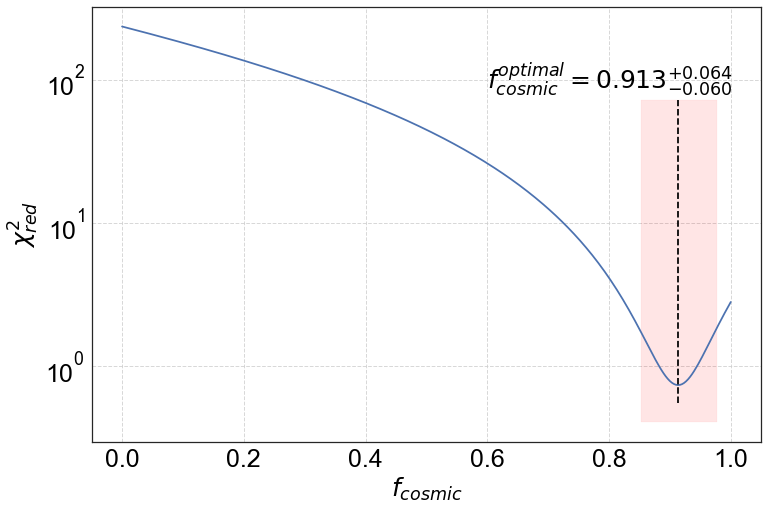

In [11]:
var='theta_12'
x_label=r'$\theta_{1,2}$ angle between the two tracks [deg.]'
bins=np.linspace(0,180,41)

f_cosmic_array = linspace(0,1,300)
overlay_scalings = dict()
chi2_array = []
for f_Cosmic in f_cosmic_array:
    overlay_scalings['N(On) scaling and f(cosmic)=%.3f'%f_Cosmic] = get_samples_scaling( N_total= float(len(OnBeamFV))
                                                                                        , debug=0
                                                                                        , f_Cosmic=f_Cosmic
                                                                                        , OverlaySubsamples=OverlaySamples)
    overlay_scaling = overlay_scalings['N(On) scaling and f(cosmic)=%.3f'%f_Cosmic]    
    x = OnBeamFV[var]
    h_OnBeam,edges = np.histogram( x , bins=bins )
    h = dict()
    for i_pair_type,pair_type in enumerate(pair_types):
        sample = OverlaySamples[pair_type]
        x = sample[var]; x = x[x<1e5];
        h[pair_type],edges = np.histogram(x,bins=bins)
        h[pair_type+' scaled'] = overlay_scaling[pair_type]*h[pair_type] if overlay_scaling else h[pair_type]
    # -- - - - --------- - - -- ---- -  - --- -- -- -- --
    h_stack = h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled']
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                     , h1=h_OnBeam , h2=h_stack
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
    chi2_array.append(chi2)    
chi2_array = np.array(chi2_array)    
print 'done chi2 computation.'


fig,ax=plt.subplots(figsize=(12,8))
plt.plot(f_cosmic_array,chi2_array/ndf)
set_axes(ax,r'$f_{cosmic}$',r'$\chi^2_{red}$',do_add_grid='True')
ax.set_yscale('log')

# best point
i_min = np.argmin(chi2_array)
f_min = f_cosmic_array[i_min]
chi2_min = chi2_array[i_min]

# lower limit
for i in range(0,i_min):
    if chi2_array[i]/ndf <= chi2_min/ndf + 1:
        chi2_min_dw = chi2_array[i]
        f_min_dw = f_cosmic_array[i]
        break

# upper limit
for i in range(i_min,len(chi2_array)):
    if chi2_array[i]/ndf >= chi2_min/ndf + 1:
        chi2_min_up = chi2_array[i]
        f_min_up = f_cosmic_array[i]
        break
print 'i_min:',i_min
print 'f_min:',f_min,'+',(f_min_up-f_min),'-',(f_min-f_min_dw)
print 'chi2_min/ndf:',(chi2_min/ndf)
print 'chi2_min_up/ndf:',(chi2_min_up/ndf)
print 'chi2_min_dw/ndf:',(chi2_min_dw/ndf)
y_max = 2.5*chi2_array[i_min]
plt.plot([f_min,f_min],[np.min(ax.get_ylim()),y_max],'--',color='black')
plt.fill_between([f_min_dw,f_min_up],[np.min(ax.get_ylim()),np.min(ax.get_ylim())],[y_max,y_max],color='red',alpha=0.1)
plt.text(0.6,1.2*y_max,r'$f _{cosmic} ^{optimal} = %.3f^{+%.3f}_{-%.3f}$'%(f_min,f_min_up-f_min,f_min-f_min_dw),fontsize=25 ,color='black') 
# plt.savefig(figures_path+'f_cosmic_vs_chi2.pdf')

In [12]:
overlay_scaling = get_samples_scaling( N_total= float(len(OnBeamFV)), debug=0, f_Cosmic=f_min, OverlaySubsamples=OverlaySamples)

## 2. apply the event-selection cuts

In [13]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order,overlay_scaling=overlay_scaling)
print 'applied cuts to overlay'

applied cuts to overlay


In [14]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

8978 events in the overlay
6979 selected CC 1p 0pi pairs in overlay


## 3. compare the shapes and rates after the event-selection cuts

In [16]:
mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

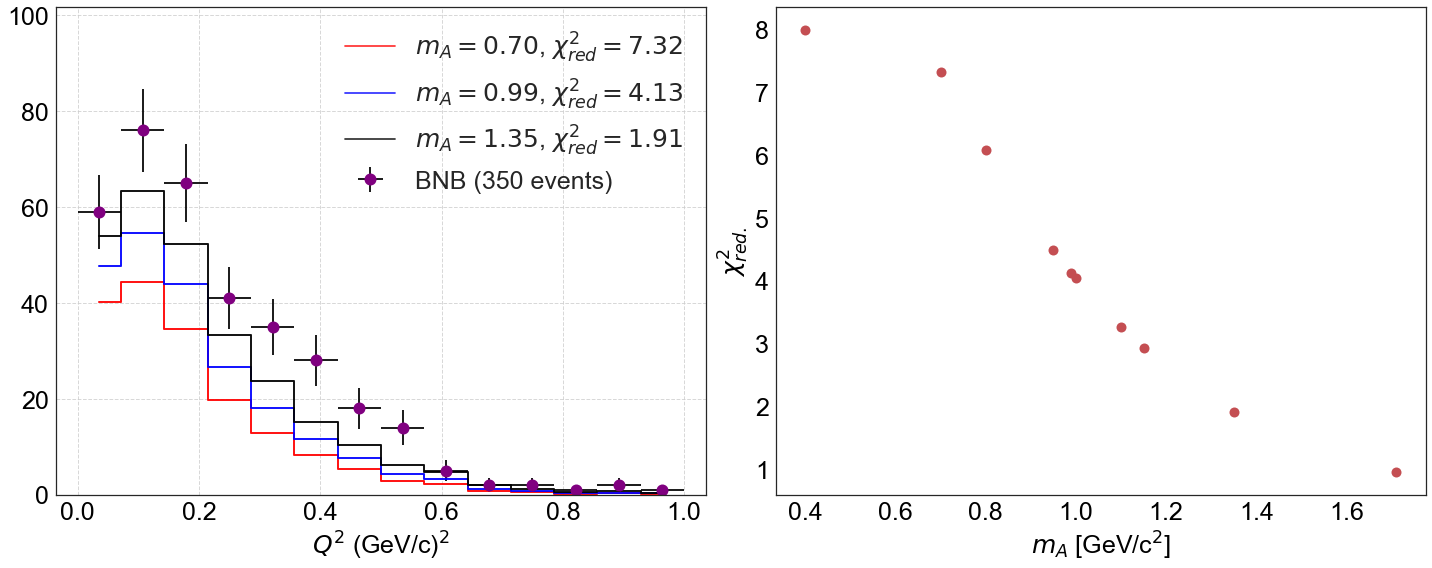

In [26]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc,do_draw=False
                                                   , overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

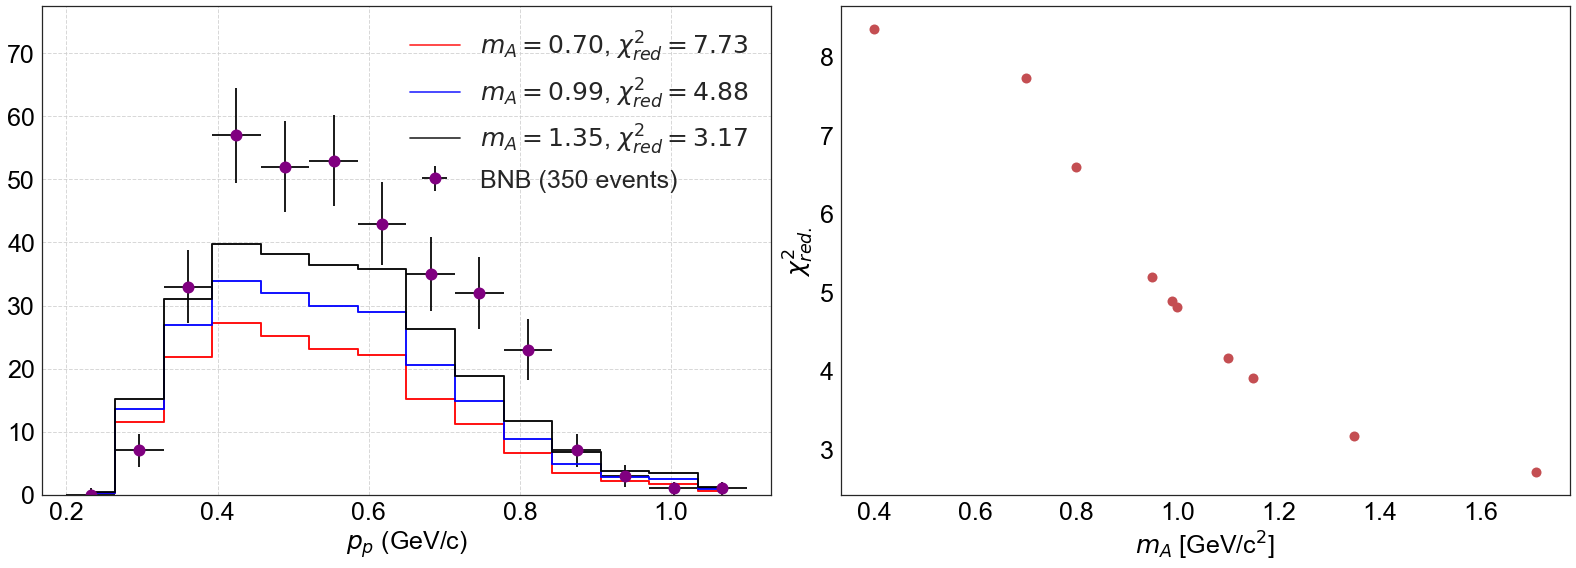

In [27]:
var,x_label = 'reco_Pp', r'$p_p$ (GeV/c)'
bins = linspace(0.2,1.1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.2,1.1)

fig=plt.figure(figsize=(22,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, do_draw=False
                                                   , overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()